## Libraries


In [61]:
# import libraries
import csv
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
from types import MethodType
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [5]:
warnings.filterwarnings(action = 'ignore')

## Data Preprocessing

In [5]:
df = pd.read_csv('data/Sunspots.csv')
del df['Unnamed: 0']


In [6]:
df.head()


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB
None


In [10]:
print(df.columns)
df.columns = ['Date', 'Sunspots']
df['Date'] = pd.to_datetime(df['Date'])

Index(['Date', 'Monthly Mean Total Sunspot Number'], dtype='object')


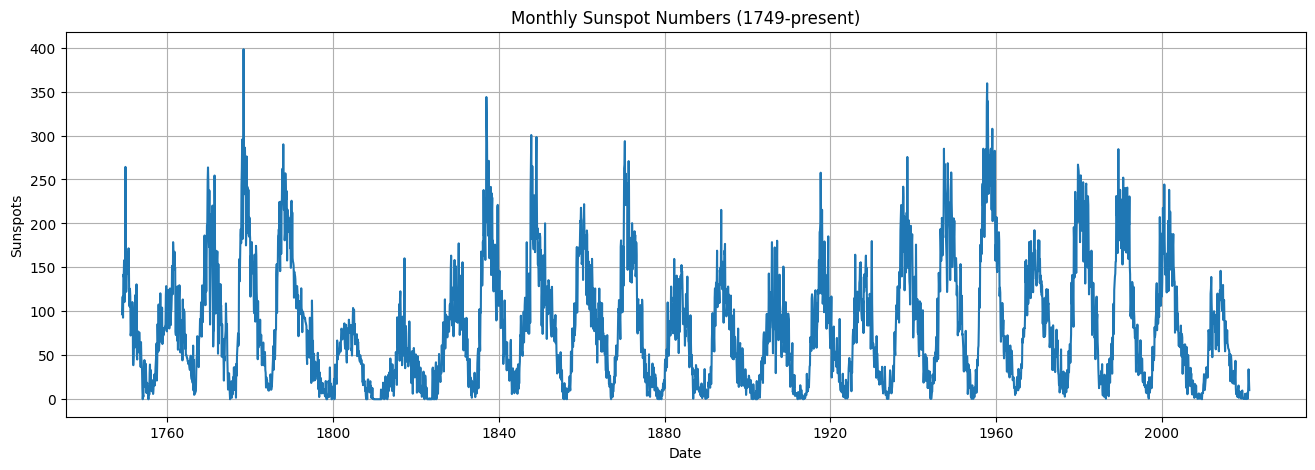

In [11]:
plt.figure(figsize=(16,5))
plt.plot(df['Date'], df['Sunspots'])
plt.title('Monthly Sunspot Numbers (1749-present)')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.grid(True)
plt.show()

### Missing vales checking


In [12]:
print(df.isnull().sum())
if df['Sunspots'].isnull().any():
    df['Sunspots'] = df['Sunspots'].interpolate(method='linear')
    
print(df.isnull().sum())

Date        0
Sunspots    0
dtype: int64
Date        0
Sunspots    0
dtype: int64


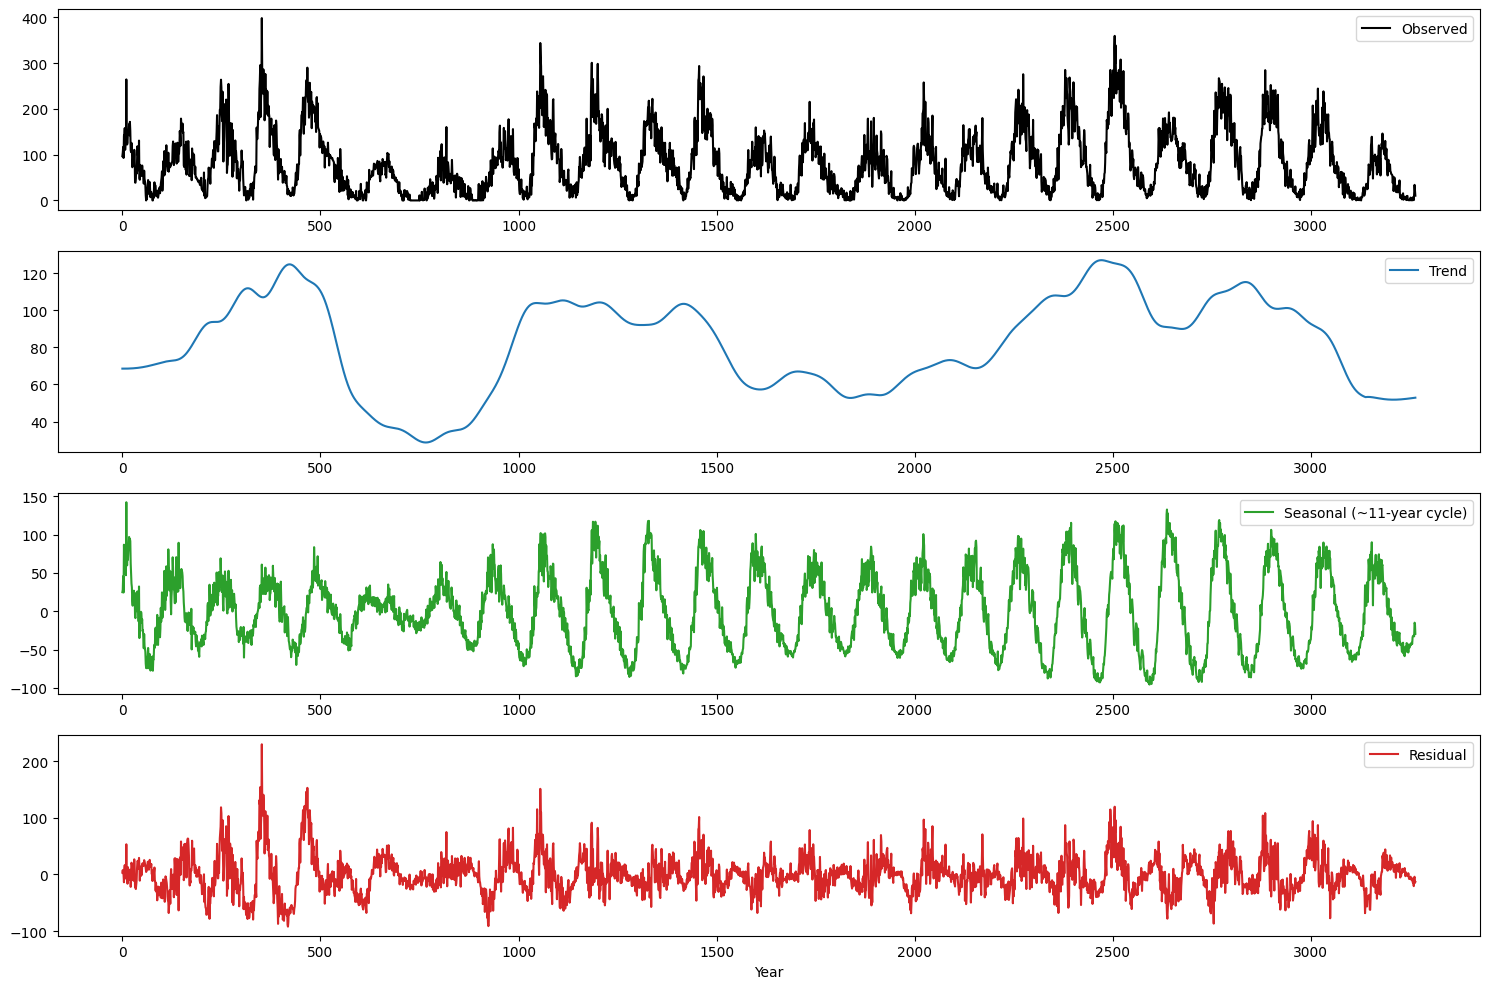

In [9]:
# STL decomposition, period ≈ 11 years = 132 months
stl = STL(df['Sunspots'], period=132)
result = stl.fit()

# Plot STL decomposition
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Sunspots'], label='Observed', color='black')
plt.legend(loc='upper right')
plt.subplot(4, 1, 2)
plt.plot(df.index, result.trend, label='Trend', color='tab:blue')
plt.legend(loc='upper right')
plt.subplot(4, 1, 3)
plt.plot(df.index, result.seasonal, label='Seasonal (~11-year cycle)', color='tab:green')
plt.legend(loc='upper right')
plt.subplot(4, 1, 4)
plt.plot(df.index, result.resid, label='Residual', color='tab:red')
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

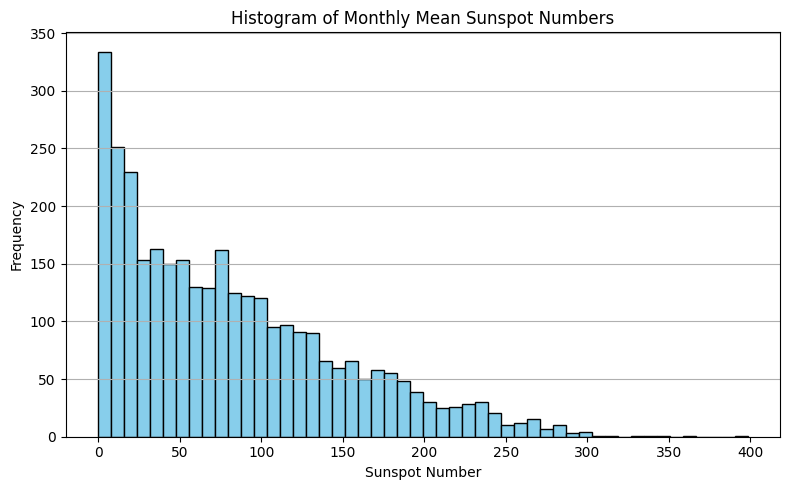

In [10]:
# 1. Histogram of Sunspot Counts
plt.figure(figsize=(8,5))
plt.hist(df['Sunspots'], bins=50, color='skyblue', edgecolor='k')
plt.title('Histogram of Monthly Mean Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

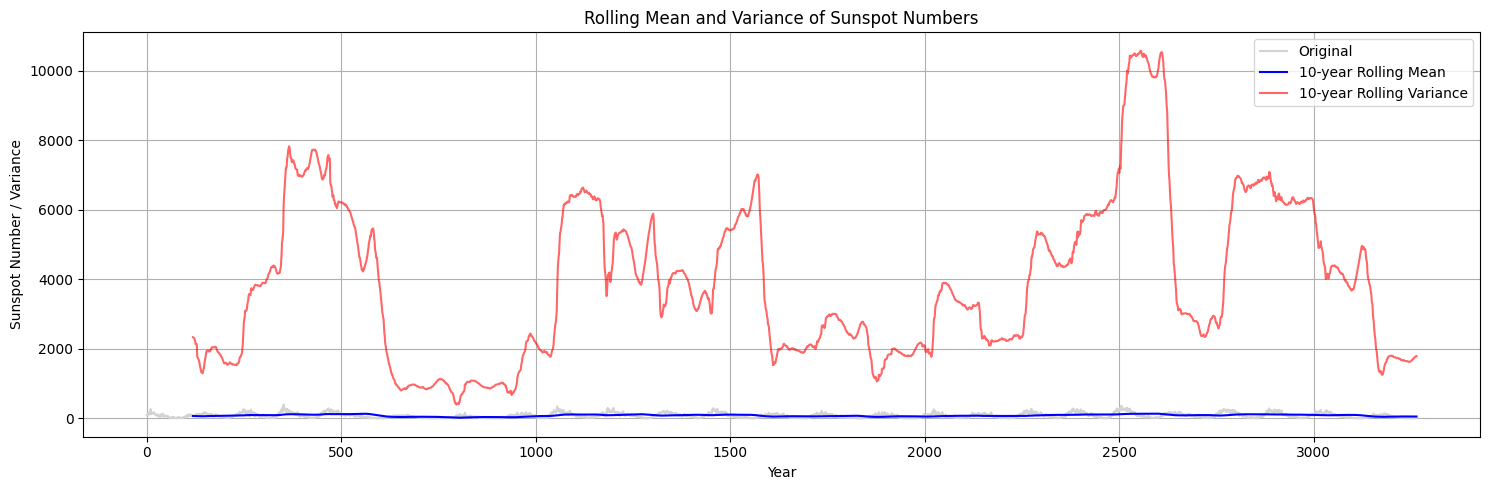

In [11]:
# 2. Rolling Mean & Variance (120 months ~ 10 years)
rolling_mean = df['Sunspots'].rolling(window=120).mean()
rolling_var = df['Sunspots'].rolling(window=120).var()

plt.figure(figsize=(15,5))
plt.plot(df.index, df['Sunspots'], color='lightgray', label='Original')
plt.plot(df.index, rolling_mean, color='blue', label='10-year Rolling Mean')
plt.plot(df.index, rolling_var, color='red', label='10-year Rolling Variance', alpha=0.6)
plt.title('Rolling Mean and Variance of Sunspot Numbers')
plt.xlabel('Year')
plt.ylabel('Sunspot Number / Variance')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

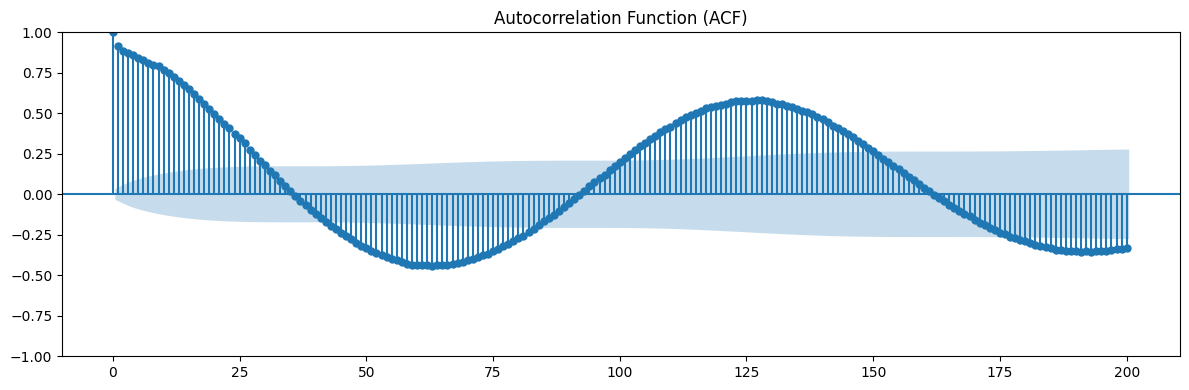

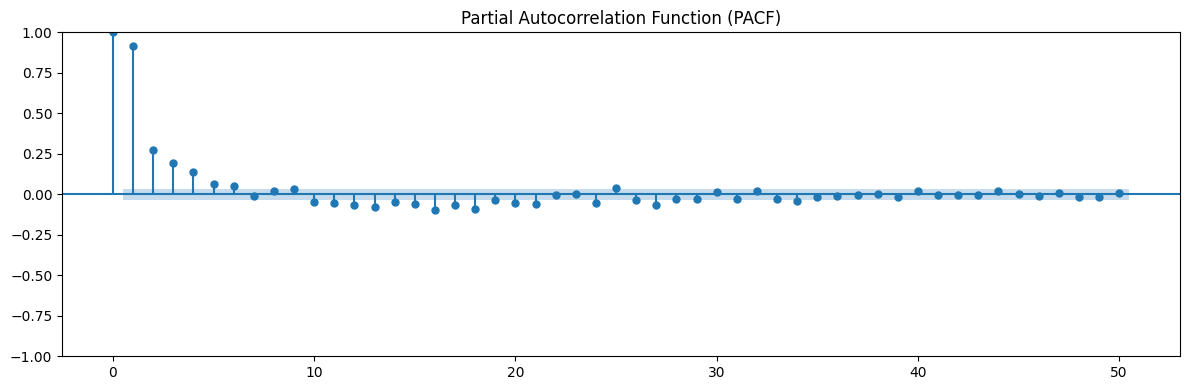

In [12]:
# 3. Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(12, 4))
plot_acf(df['Sunspots'], lags=200, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))
plot_pacf(df['Sunspots'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


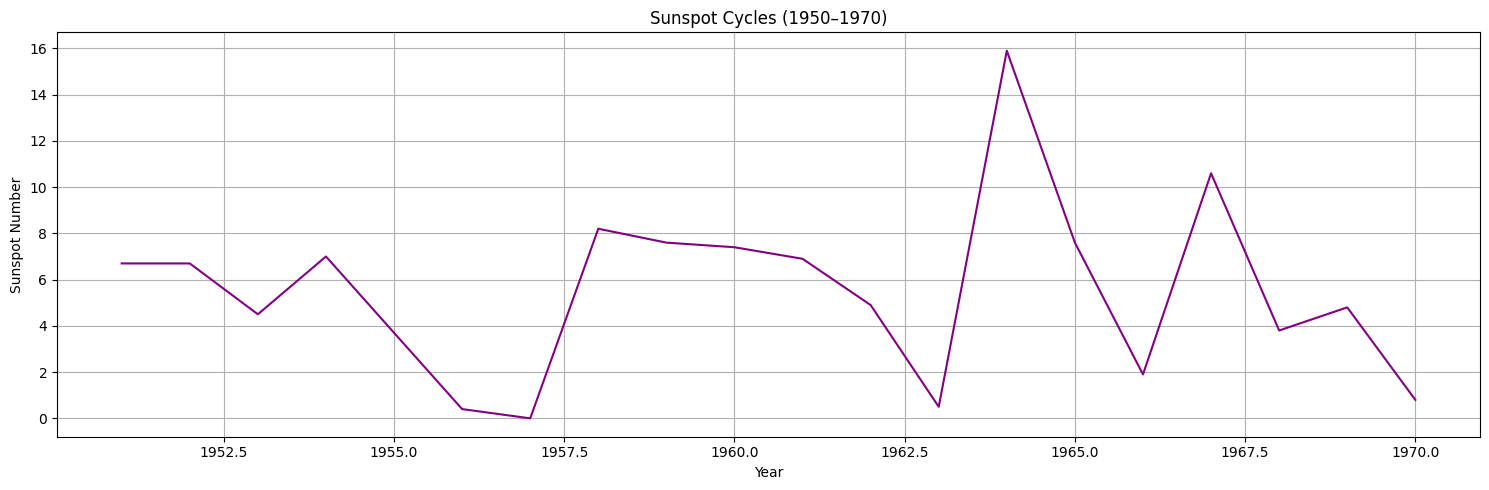

In [13]:
df_zoom = df.loc['1950-01-01':'1970-12-31']
plt.figure(figsize=(15,5))
plt.plot(df_zoom.index, df_zoom['Sunspots'], color='purple')
plt.title('Sunspot Cycles (1950–1970)')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.grid()
plt.tight_layout()
plt.show()


In [14]:
def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Set window size (e.g., 12 months)
window_size = 12

# Use the cleaned sunspot values
sunspot_series = df['Sunspots'].values

# Create input/output arrays
X, y = create_windowed_dataset(sunspot_series, window_size)

print('X shape:', X.shape)  # (num_samples, window_size)
print('y shape:', y.shape)  # (num_samples,)

# Train-test split (e.g., last 20 years as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)


X shape: (3253, 12)
y shape: (3253,)
Train: (2602, 12) (2602,)
Test: (651, 12) (651,)


In [ ]:

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print('X_train_scaled mean/std:', X_train_scaled.mean(), X_train_scaled.std())
print('y_train_scaled mean/std:', y_train_scaled.mean(), y_train_scaled.std())


X_train_scaled mean/std: -1.2816348603000525e-15 0.9999999999999998
y_train_scaled mean/std: -2.0753746317358807e-16 1.0


# 2. Bayesian Neural Network for Sunspot Forecasting (with Pyro)

In [19]:
# Convert to torch tensors for Pyro
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_scaled, dtype=torch.float32)

In [20]:
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def forward(self, x, w1, b1, w2, b2):
        x = torch.matmul(x, w1.t()) + b1
        x = torch.relu(x)
        x = torch.matmul(x, w2.t()) + b2
        return x

def bnn_model(X, y=None):
    # Tighter priors: stddev = 0.1
    prior_std = 0.1
    w1 = pyro.sample('w1', dist.Normal(torch.zeros(32, X.shape[1]), prior_std * torch.ones(32, X.shape[1])).to_event(2))
    b1 = pyro.sample('b1', dist.Normal(torch.zeros(32), prior_std * torch.ones(32)).to_event(1))
    w2 = pyro.sample('w2', dist.Normal(torch.zeros(1, 32), prior_std * torch.ones(1, 32)).to_event(2))
    b2 = pyro.sample('b2', dist.Normal(torch.zeros(1), prior_std * torch.ones(1)).to_event(1))
    sigma = pyro.sample('sigma', dist.Uniform(0.05, 1.0))
    output = BNN(X.shape[1])(X, w1, b1, w2, b2).squeeze(-1)
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Normal(output, sigma), obs=y)

def bnn_guide(X, y=None):
    # Variational params for all weights/biases
    w1_loc = pyro.param('w1_loc', torch.randn(32, X.shape[1]) * 0.01)
    w1_scale = pyro.param('w1_scale', torch.ones(32, X.shape[1]) * 0.1, constraint=dist.constraints.positive)
    b1_loc = pyro.param('b1_loc', torch.randn(32) * 0.01)
    b1_scale = pyro.param('b1_scale', torch.ones(32) * 0.1, constraint=dist.constraints.positive)
    w2_loc = pyro.param('w2_loc', torch.randn(1, 32) * 0.01)
    w2_scale = pyro.param('w2_scale', torch.ones(1, 32) * 0.1, constraint=dist.constraints.positive)
    b2_loc = pyro.param('b2_loc', torch.randn(1) * 0.01)
    b2_scale = pyro.param('b2_scale', torch.ones(1) * 0.1, constraint=dist.constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(0.1), constraint=dist.constraints.positive)

    pyro.sample('w1', dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample('b1', dist.Normal(b1_loc, b1_scale).to_event(1))
    pyro.sample('w2', dist.Normal(w2_loc, w2_scale).to_event(2))
    pyro.sample('b2', dist.Normal(b2_loc, b2_scale).to_event(1))
    pyro.sample('sigma', dist.Uniform(sigma_loc, sigma_loc + 0.01))


In [22]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.01})
svi = SVI(bnn_model, bnn_guide, optimizer, loss=Trace_ELBO())

num_steps = 3000  # You can try 2000 if you wish
for step in range(num_steps):
    loss = svi.step(X_train_torch, y_train_torch)
    if (step + 1) % 300 == 0 or step == 0:
        print(f"Step {step + 1}/{num_steps} : ELBO Loss = {loss:.2f}")


Step 1/3000 : ELBO Loss = 112682.28
Step 300/3000 : ELBO Loss = 2143.66
Step 600/3000 : ELBO Loss = 1450.79
Step 900/3000 : ELBO Loss = 1376.15
Step 1200/3000 : ELBO Loss = 1504.37
Step 1500/3000 : ELBO Loss = 1537.14
Step 1800/3000 : ELBO Loss = 1629.82
Step 2100/3000 : ELBO Loss = 1417.28
Step 2400/3000 : ELBO Loss = 1378.22
Step 2700/3000 : ELBO Loss = 1396.00
Step 3000/3000 : ELBO Loss = 1343.57


In [23]:
def sample_bnn_predictions(X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        guide_trace = pyro.poutine.trace(bnn_guide).get_trace(X)
        w1 = guide_trace.nodes['w1']['value']
        b1 = guide_trace.nodes['b1']['value']
        w2 = guide_trace.nodes['w2']['value']
        b2 = guide_trace.nodes['b2']['value']
        pred = BNN(X.shape[1])(X, w1, b1, w2, b2).squeeze(-1).detach().cpu().numpy()
        preds.append(pred)
    preds = np.stack(preds, axis=0)  # (n_samples, batch)
    return preds.mean(axis=0), preds.std(axis=0)

mean_pred_test, std_pred_test = sample_bnn_predictions(X_test_torch, n_samples=100)
mean_pred_test_orig = scaler_y.inverse_transform(mean_pred_test.reshape(-1,1)).flatten()
std_pred_test_orig = std_pred_test * scaler_y.scale_[0]
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()


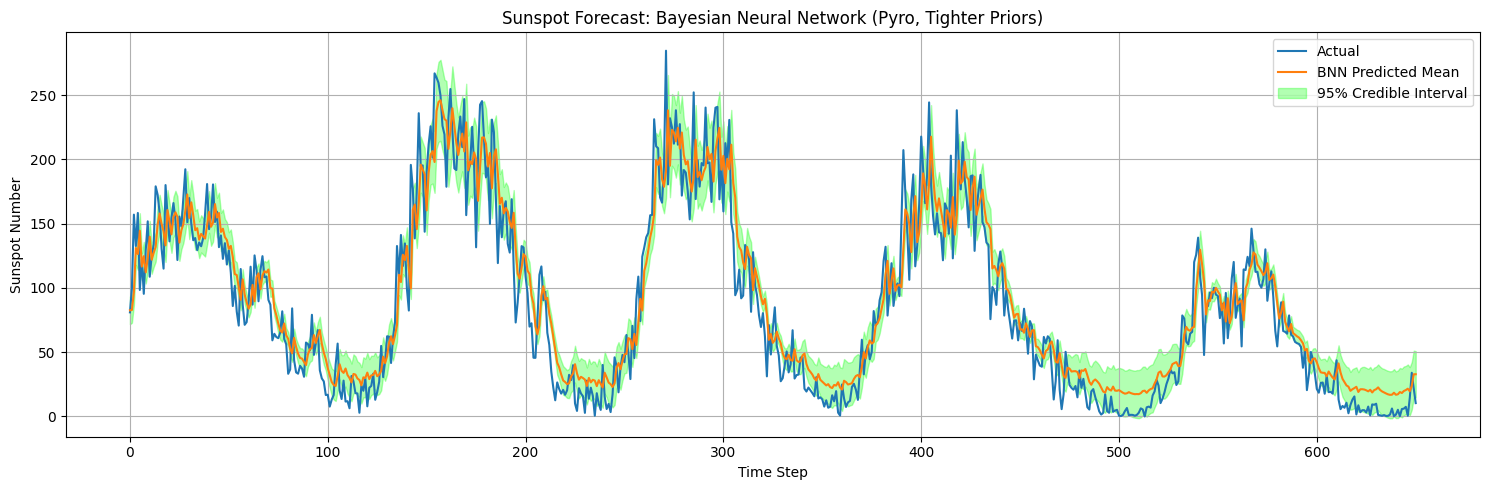

In [24]:
plt.figure(figsize=(15,5))
plt.plot(y_test_orig, label='Actual')
plt.plot(mean_pred_test_orig, label='BNN Predicted Mean')
plt.fill_between(np.arange(len(y_test_orig)),
                 mean_pred_test_orig - 2*std_pred_test_orig,
                 mean_pred_test_orig + 2*std_pred_test_orig,
                 color='lime', alpha=0.3, label='95% Credible Interval')
plt.title('Sunspot Forecast: Bayesian Neural Network (Pyro, Tighter Priors)')
plt.xlabel('Time Step')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [27]:

# Pyro BNN
rmse_bnn = np.sqrt(mean_squared_error(y_test_orig, mean_pred_test_orig))
mae_bnn = mean_absolute_error(y_test_orig, mean_pred_test_orig)
print(f"Pyro Bayesian NN   RMSE: {rmse_bnn:.2f}, MAE: {mae_bnn:.2f}")


Pyro Bayesian NN   RMSE: 23.96, MAE: 18.72


# 2.1 Try Longer Input Windows (24, 36 Months)

In [ ]:
window_size = 24 

def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    X = np.array(X)
    y = np.array(y)
    return X, y

sunspot_series = df['Sunspots'].values  # Use your preprocessed df
X, y = create_windowed_dataset(sunspot_series, window_size)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_scaled, dtype=torch.float32)


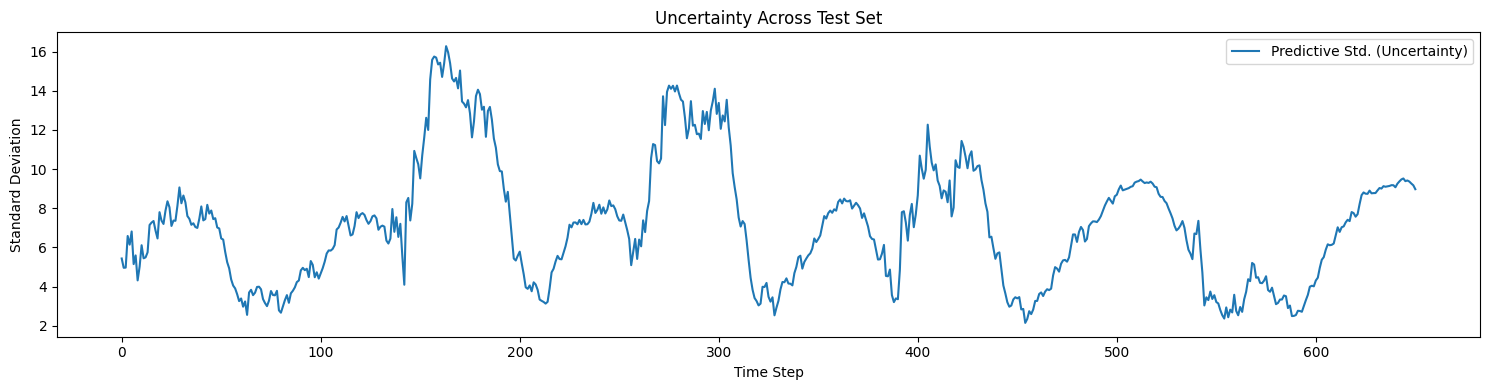

Top 10 highest uncertainty points (test set indices):
[163 164 157 158 156 160 165 162 159 170]


In [29]:
plt.figure(figsize=(15,4))
plt.plot(std_pred_test_orig, label='Predictive Std. (Uncertainty)')
plt.title('Uncertainty Across Test Set')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

# Top 10 most uncertain predictions
most_uncertain_indices = np.argsort(-std_pred_test_orig)[:10]
print("Top 10 highest uncertainty points (test set indices):")
print(most_uncertain_indices)


In [30]:
window_size = 48

def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

sunspot_series = df['Sunspots'].values
X, y = create_windowed_dataset(sunspot_series, window_size)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_scaled, dtype=torch.float32)

In [ ]:
class DeepBNN(nn.Module):
    def __init__(self, input_dim, h1=64, h2=32):
        super().__init__()
        self.input_dim = input_dim
        self.h1 = h1
        self.h2 = h2

    def forward(self, x, w1, b1, w2, b2, w3, b3):
        x = torch.matmul(x, w1.t()) + b1
        x = torch.relu(x)
        x = torch.matmul(x, w2.t()) + b2
        x = torch.relu(x)
        x = torch.matmul(x, w3.t()) + b3
        return x

def deep_bnn_model(X, y=None):
    prior_std = 0.05  #  tight prior for stability in deep nets
    # Priors
    w1 = pyro.sample('w1', dist.Normal(torch.zeros(64, X.shape[1]), prior_std * torch.ones(64, X.shape[1])).to_event(2))
    b1 = pyro.sample('b1', dist.Normal(torch.zeros(64), prior_std * torch.ones(64)).to_event(1))
    w2 = pyro.sample('w2', dist.Normal(torch.zeros(32, 64), prior_std * torch.ones(32, 64)).to_event(2))
    b2 = pyro.sample('b2', dist.Normal(torch.zeros(32), prior_std * torch.ones(32)).to_event(1))
    w3 = pyro.sample('w3', dist.Normal(torch.zeros(1, 32), prior_std * torch.ones(1, 32)).to_event(2))
    b3 = pyro.sample('b3', dist.Normal(torch.zeros(1), prior_std * torch.ones(1)).to_event(1))
    sigma = pyro.sample('sigma', dist.Uniform(0.01, 1.0))
    output = DeepBNN(X.shape[1])(X, w1, b1, w2, b2, w3, b3).squeeze(-1)
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Normal(output, sigma), obs=y)

def deep_bnn_guide(X, y=None):
    # Means and scales for all weights/biases
    w1_loc = pyro.param('w1_loc', torch.randn(64, X.shape[1]) * 0.01)
    w1_scale = pyro.param('w1_scale', torch.ones(64, X.shape[1]) * 0.05, constraint=dist.constraints.positive)
    b1_loc = pyro.param('b1_loc', torch.randn(64) * 0.01)
    b1_scale = pyro.param('b1_scale', torch.ones(64) * 0.05, constraint=dist.constraints.positive)
    w2_loc = pyro.param('w2_loc', torch.randn(32, 64) * 0.01)
    w2_scale = pyro.param('w2_scale', torch.ones(32, 64) * 0.05, constraint=dist.constraints.positive)
    b2_loc = pyro.param('b2_loc', torch.randn(32) * 0.01)
    b2_scale = pyro.param('b2_scale', torch.ones(32) * 0.05, constraint=dist.constraints.positive)
    w3_loc = pyro.param('w3_loc', torch.randn(1, 32) * 0.01)
    w3_scale = pyro.param('w3_scale', torch.ones(1, 32) * 0.05, constraint=dist.constraints.positive)
    b3_loc = pyro.param('b3_loc', torch.randn(1) * 0.01)
    b3_scale = pyro.param('b3_scale', torch.ones(1) * 0.05, constraint=dist.constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(0.1), constraint=dist.constraints.positive)

    pyro.sample('w1', dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample('b1', dist.Normal(b1_loc, b1_scale).to_event(1))
    pyro.sample('w2', dist.Normal(w2_loc, w2_scale).to_event(2))
    pyro.sample('b2', dist.Normal(b2_loc, b2_scale).to_event(1))
    pyro.sample('w3', dist.Normal(w3_loc, w3_scale).to_event(2))
    pyro.sample('b3', dist.Normal(b3_loc, b3_scale).to_event(1))
    pyro.sample('sigma', dist.Uniform(sigma_loc, sigma_loc + 0.01))


In [32]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.01})
svi = SVI(deep_bnn_model, deep_bnn_guide, optimizer, loss=Trace_ELBO())

num_steps = 3000
for step in range(num_steps):
    loss = svi.step(X_train_torch, y_train_torch)
    if (step + 1) % 300 == 0 or step == 0:
        print(f"Step {step + 1}/{num_steps} : ELBO Loss = {loss:.2f}")


Step 1/3000 : ELBO Loss = 108037.04
Step 300/3000 : ELBO Loss = 3737.85
Step 600/3000 : ELBO Loss = 2174.57
Step 900/3000 : ELBO Loss = 2193.43
Step 1200/3000 : ELBO Loss = 2078.19
Step 1500/3000 : ELBO Loss = 2002.08
Step 1800/3000 : ELBO Loss = 2391.35
Step 2100/3000 : ELBO Loss = 2354.73
Step 2400/3000 : ELBO Loss = 2276.20
Step 2700/3000 : ELBO Loss = 2099.53
Step 3000/3000 : ELBO Loss = 2123.97


In [33]:
def sample_deep_bnn_predictions(X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        guide_trace = pyro.poutine.trace(deep_bnn_guide).get_trace(X)
        w1 = guide_trace.nodes['w1']['value']
        b1 = guide_trace.nodes['b1']['value']
        w2 = guide_trace.nodes['w2']['value']
        b2 = guide_trace.nodes['b2']['value']
        w3 = guide_trace.nodes['w3']['value']
        b3 = guide_trace.nodes['b3']['value']
        pred = DeepBNN(X.shape[1])(X, w1, b1, w2, b2, w3, b3).squeeze(-1).detach().cpu().numpy()
        preds.append(pred)
    preds = np.stack(preds, axis=0)
    return preds.mean(axis=0), preds.std(axis=0)

mean_pred_test, std_pred_test = sample_deep_bnn_predictions(X_test_torch, n_samples=100)
mean_pred_test_orig = scaler_y.inverse_transform(mean_pred_test.reshape(-1,1)).flatten()
std_pred_test_orig = std_pred_test * scaler_y.scale_[0]
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()


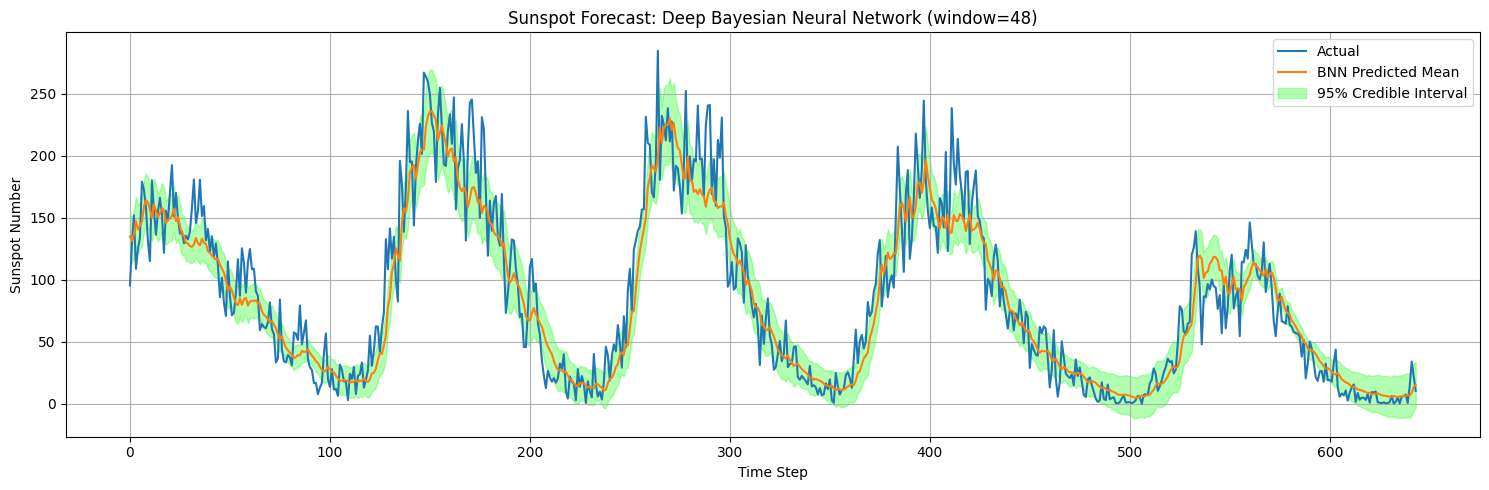

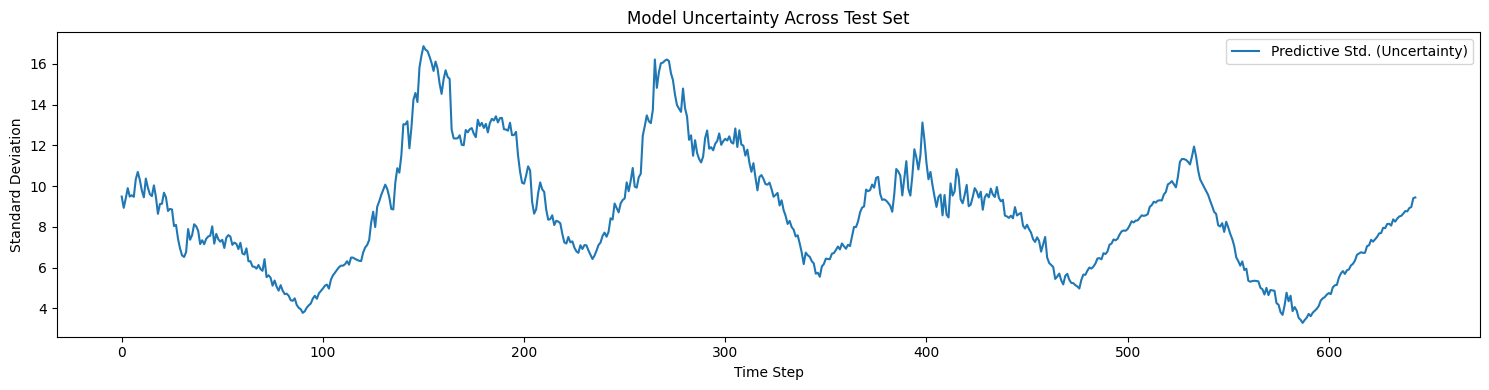

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_orig, label='Actual')
plt.plot(mean_pred_test_orig, label='BNN Predicted Mean')
plt.fill_between(np.arange(len(y_test_orig)),
                 mean_pred_test_orig - 2*std_pred_test_orig,
                 mean_pred_test_orig + 2*std_pred_test_orig,
                 color='lime', alpha=0.3, label='95% Credible Interval')
plt.title(f'Sunspot Forecast: Deep Bayesian Neural Network (window={window_size})')
plt.xlabel('Time Step')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(std_pred_test_orig, label='Predictive Std. (Uncertainty)')
plt.title('Model Uncertainty Across Test Set')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_bnn = np.sqrt(mean_squared_error(y_test_orig, mean_pred_test_orig))
mae_bnn = mean_absolute_error(y_test_orig, mean_pred_test_orig)
print(f"Deep Pyro BNN Test RMSE: {rmse_bnn:.2f}, MAE: {mae_bnn:.2f}")


Deep Pyro BNN Test RMSE: 24.33, MAE: 17.89


# 3. Bayesian Neural Network regression for sunspot forecasting with MCMC 

In [37]:
df['Date'] = pd.to_datetime(df['Date'])
df['Sunspots'] = df['Sunspots'].interpolate(method='linear')
series = df['Sunspots'].values

/var/folders/d2/zq39cz7s6nl4c16p3c8k94x00000gn/T/ipykernel_3149/3103937989.py:192: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fx[i] = fx_tmp


Available columns in CSV: ['Date', 'Monthly Mean Total Sunspot Number']
Initial NN output sanity check:
Initial NN outputs (first 10): [0.15810484 0.15655908 0.09761963 0.09382809 0.32722094 0.31123373
 0.26361248 0.19619823 0.23641927 0.21899901]
Any NaNs in initial NN outputs: False
Running MCMC...


100%|██████████| 9999/9999 [01:39<00:00, 100.45it/s]

52.9% were accepted
Any NaNs in y_test_orig: False
Any NaNs in mean_pred_orig: False
Sample y_test_orig: [157.  132.6 158.3  98.4 122.5  95.4 129.5 151.8 108.7 125. ]
Sample mean_pred_orig: [ 93.61544409 126.89881076 126.18749826 165.66467164 114.65599236
 147.93641961 127.80244268 140.21188849 150.13434956 135.90568502]


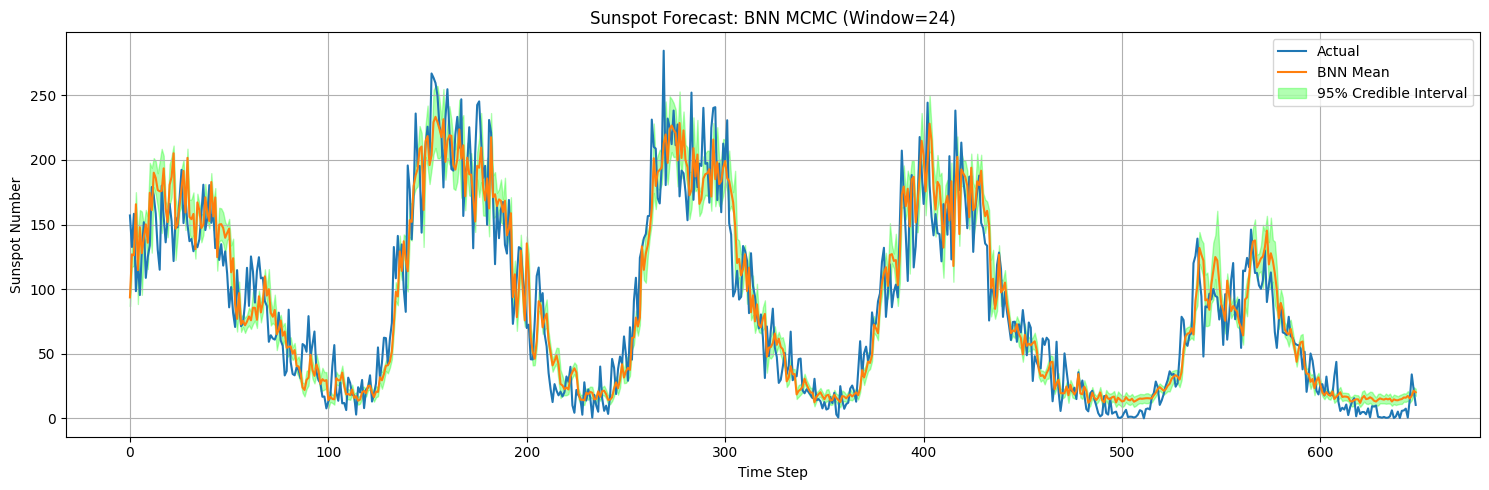

MCMC BNN Test RMSE: 24.65, MAE: 18.56


In [63]:
np.random.seed(42)
df = pd.read_csv('data/Sunspots.csv')
if 'Unnamed: 0' in df.columns:
    del df['Unnamed: 0']
if 'Sunspots' in df.columns:
    series = df['Sunspots'].values.astype(np.float32)
else:
    print("Available columns in CSV:", df.columns.tolist())
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found in the CSV file.")
    series = df[numeric_cols[0]].values.astype(np.float32)

# --- WINDOWING ---
window_size = 24
X, y = [], []
for i in range(len(series) - window_size):
    X.append(series[i:i+window_size])
    y.append(series[i+window_size])
X = np.array(X)
y = np.array(y)

# --- TRAIN-TEST SPLIT ---
split_idx = int(len(X) * 0.8)
x_data, x_test = X[:split_idx], X[split_idx:]
y_data, y_test = y[:split_idx], y[split_idx:]

# --- STANDARDIZATION ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_data = scaler_X.fit_transform(x_data)
x_test = scaler_X.transform(x_test)
y_data = scaler_y.fit_transform(y_data.reshape(-1,1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# --- Neural Network Class ---
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01): 
        self.input_num = layer_sizes[0]
        self.hidden_num = layer_sizes[1]
        self.output_num = layer_sizes[2]
        self.n_params = (self.input_num * self.hidden_num) + (self.hidden_num * self.output_num) + self.hidden_num + self.output_num
        self.lrate = learning_rate
        self.initialise_network()
        self.forward_pass = MethodType(forward_pass, self)
        self.backward_pass = MethodType(backward_pass, self)
    
    def initialise_network(self):
        self.l1_weights = np.random.normal(0, 1/np.sqrt(self.input_num), size=(self.input_num, self.hidden_num))
        self.l1_biases = np.random.normal(0, 1/np.sqrt(self.hidden_num), size=(self.hidden_num,))
        self.l1_output = np.zeros((1, self.hidden_num))
        self.l2_weights = np.random.normal(0, 1/np.sqrt(self.hidden_num), size=(self.hidden_num, self.output_num))
        self.l2_biases = np.random.normal(0, 1/np.sqrt(self.hidden_num), size=(self.output_num,))
        self.l2_output = np.zeros((1, self.output_num))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def encode(self):
        w1 = self.l1_weights.ravel()
        w2 = self.l2_weights.ravel()
        theta = np.concatenate([w1, w2, self.l1_biases, self.l2_biases])
        return theta
    
    def decode(self, theta):
        w_layer1size = self.input_num * self.hidden_num
        w_layer2size = self.hidden_num * self.output_num
        w_layer1 = theta[0:w_layer1size]
        self.l1_weights = np.reshape(w_layer1, (self.input_num, self.hidden_num))
        w_layer2 = theta[w_layer1size:w_layer1size + w_layer2size]
        self.l2_weights = np.reshape(w_layer2, (self.hidden_num, self.output_num))
        self.l1_biases = theta[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.hidden_num]
        self.l2_biases = theta[w_layer1size + w_layer2size + self.hidden_num:w_layer1size + w_layer2size + self.hidden_num + self.output_num]

def forward_pass(self, X):
    l1_z = np.dot(X, self.l1_weights) + self.l1_biases
    self.l1_output = self.sigmoid(l1_z)
    l2_z = np.dot(self.l1_output, self.l2_weights) + self.l2_biases
    self.l2_output = l2_z  # Linear output!
    return self.l2_output

def backward_pass(self, X, Y):
    l2_delta = (Y - self.l2_output) # For linear output
    l2_weights_delta = np.outer(self.l1_output, l2_delta)
    l1_delta = np.dot(l2_delta,self.l2_weights.T) * (self.l1_output * (1 - self.l1_output))
    l1_weights_delta = np.outer(X, l1_delta)
    self.l2_weights += self.lrate * l2_weights_delta
    self.l2_biases += self.lrate * l2_delta
    self.l1_weights += self.lrate * l1_weights_delta
    self.l1_biases += self.lrate * l1_delta

def likelihood_function(self, theta, tausq, test=False):
    epsilon = 1e-8
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    model_prediction, _ = self.model.evaluate_proposal(x_data, theta)
    model_simulation = model_prediction + np.random.normal(0, np.sqrt(tausq+epsilon), size=model_prediction.shape)
    accuracy = self.rmse(model_prediction, y_data)
    log_likelihood = np.sum(-0.5 * np.log(2 * np.pi * (tausq+epsilon)) - 0.5 * np.square(y_data - model_prediction) / (tausq+epsilon))
    return [log_likelihood, model_prediction, model_simulation, accuracy] 

def prior(self, sigma_squared, nu_1, nu_2, theta, tausq): 
    n_params = self.theta_size
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2 - (1 + nu_1) * np.log(tausq+1e-8) - (nu_2 / (tausq+1e-8))
    return log_prior

def sampler(self):
    pos_theta = np.ones((self.n_samples, self.theta_size)) 
    pos_tau = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    rmse_data = np.zeros(self.n_samples)
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)
    theta = np.random.randn(self.theta_size)
    pred_y[0,], _ = self.model.evaluate_proposal(self.x_data, theta)
    eta = np.log(np.var(pred_y[0,] - self.y_data)+1e-8)
    tau_proposal = np.exp(eta)
    sigma_squared = self.sigma_squared
    nu_1 = self.nu_1
    nu_2 = self.nu_2
    prior_val = self.prior(sigma_squared, nu_1, nu_2, theta, tau_proposal)
    [likelihood, pred_y[0,], sim_y[0,], rmse_data[0]] = self.likelihood_function(theta, tau_proposal)
    n_accept = 0  
    n_langevin = 0
    for ii in tqdm(np.arange(1,self.n_samples)):
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)
        diff_prop = 0
        if self.use_langevin_gradients and (np.random.rand() < self.l_prob):
            theta_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta.copy(), self.sgd_depth)  
            theta_proposal = np.random.normal(theta_gd, self.step_theta, self.theta_size)
            theta_proposal_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta_proposal.copy(), self.sgd_depth) 
            wc_delta = (theta - theta_proposal_gd) 
            wp_delta = (theta_proposal - theta_gd)
            sigma_sq = self.step_theta
            first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq
            second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq
            diff_prop =  first - second
            n_langevin += 1
        eta_proposal = eta + np.random.normal(0, self.step_eta, 1)
        tau_proposal = np.exp(eta_proposal)   
        prior_proposal = self.prior(sigma_squared, nu_1, nu_2, theta_proposal, tau_proposal)
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(theta_proposal, tau_proposal)
        [_, test_pred_y[ii,], test_sim_y[ii,], test_rmse_data[ii]] = self.likelihood_function(theta_proposal, tau_proposal, test=True)
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val
        mh_prob = min(1, np.exp(diff_likelihood + diff_prior + diff_prop))
        u = np.random.uniform(0, 1)
        if u < mh_prob:
            n_accept += 1
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            eta = eta_proposal
            pos_theta[ii,] = theta_proposal
            pos_tau[ii,] = tau_proposal
            pos_eta[ii,] = eta_proposal
        else:
            pos_theta[ii,] = pos_theta[ii-1,]
            pos_tau[ii,] = pos_tau[ii-1,]
            pos_eta[ii,] = pos_eta[ii-1,]
        # DEBUG: Early break if NaNs appear in test prediction
        if np.isnan(test_pred_y[ii,]).any():
            print(f"NaN detected in test_pred_y at sample {ii}. Breaking for debug.")
            break
    accept_ratio = (n_accept / self.n_samples) * 100
    print('{:.3}% were accepted'.format(accept_ratio))
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.pos_tau = pos_tau[self.n_burnin:, ]
    self.pos_eta = pos_eta[self.n_burnin:, ]
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]
    return pred_dict

def evaluate_proposal(self, x_data, theta):
    self.decode(theta)
    size = x_data.shape[0]
    fx = np.zeros(size)
    for i in range(0, size):
        fx_tmp = self.forward_pass(x_data[i,])
        fx[i] = fx_tmp
    prob = np.zeros((size, self.output_num))
    return fx, prob

def langevin_gradient(self, x_data, y_data, theta, depth):
    self.decode(theta)
    size = x_data.shape[0]
    for _ in range(0, depth):
        for ii in range(0, size):
            self.forward_pass(x_data[ii,])
            self.backward_pass(x_data[ii,], y_data[ii])
    theta_updated = self.encode()
    return theta_updated

class MCMC:
    def __init__(self, model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples
        self.n_burnin = n_burnin
        self.x_data = x_data
        self.y_data = y_data
        self.x_test = x_test
        self.y_test = y_test
        self.step_theta = 0.005  # Lower for stability
        self.step_eta = 0.01
        self.sigma_squared = 25
        self.nu_1 = 0
        self.nu_2 = 0
        self.model = model
        self.use_langevin_gradients = False  # For debugging stability
        self.sgd_depth = 1
        self.l_prob = 0.5
        self.theta_size = self.model.n_params
        self.pos_theta = None
        self.pos_tau = None
        self.pos_eta = None
        self.rmse_data = None
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)
        self.model.evaluate_proposal = MethodType(evaluate_proposal, self.model)
        self.model.langevin_gradient = MethodType(langevin_gradient, self.model)

    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
print("Initial NN output sanity check:")
nn_model = NeuralNetwork([x_data.shape[1], 10, 1], learning_rate=0.001)
raw_pred = []
for i in range(x_test.shape[0]):
    out = nn_model.forward_pass(x_test[i])
    raw_pred.append(out)
raw_pred = np.array(raw_pred).flatten()
print("Initial NN outputs (first 10):", raw_pred[:10])
print("Any NaNs in initial NN outputs:", np.isnan(raw_pred).any())
n_samples = 10000
burn_in = int(n_samples*0.5)
hidden = 10
layer_sizes = [x_data.shape[1], hidden, 1]
nn_model = NeuralNetwork(layer_sizes, learning_rate=0.01)
mcmc = MCMC(nn_model, n_samples, burn_in, x_data, y_data, x_test, y_test)
print("Running MCMC...")
pred = mcmc.sampler()
# ---- Posterior Predictive Summaries ----
test_preds = pred['test_pred']
mean_pred = test_preds.mean(axis=0)
std_pred = test_preds.std(axis=0)
# NaN-handling and clamping for stability
mean_pred = np.where(np.isnan(mean_pred), 0, mean_pred)
mean_pred = np.clip(mean_pred, -10, 10)
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
mean_pred_orig = scaler_y.inverse_transform(mean_pred.reshape(-1,1)).flatten()
std_pred_orig = std_pred * scaler_y.scale_[0]

print("Any NaNs in y_test_orig:", np.isnan(y_test_orig).any())
print("Any NaNs in mean_pred_orig:", np.isnan(mean_pred_orig).any())
print("Sample y_test_orig:", y_test_orig[:10])
print("Sample mean_pred_orig:", mean_pred_orig[:10])

mask = (~np.isnan(mean_pred_orig)) & (~np.isnan(y_test_orig))
rmse = np.sqrt(mean_squared_error(y_test_orig[mask], mean_pred_orig[mask]))
mae = mean_absolute_error(y_test_orig[mask], mean_pred_orig[mask])

# ---- Visualization ----
plt.figure(figsize=(15,5))
plt.plot(y_test_orig, label='Actual')
plt.plot(mean_pred_orig, label='BNN Mean')
plt.fill_between(np.arange(len(y_test_orig)),
                 mean_pred_orig - 2*std_pred_orig,
                 mean_pred_orig + 2*std_pred_orig,
                 color='lime', alpha=0.3, label='95% Credible Interval')
plt.title('Sunspot Forecast: BNN MCMC (Window={})'.format(window_size))
plt.xlabel('Time Step')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"MCMC BNN Test RMSE: {rmse:.2f}, MAE: {mae:.2f}")


# 4. Standart methods 

In [ ]:
# --- ARIMA ---
arima_order = (12, 1, 0)  
arima_model = ARIMA(series[:split_idx+window_size], order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(y_test))
arima_rmse = root_mean_squared_error(y_test_orig, arima_forecast)
arima_mae = mean_absolute_error(y_test_orig, arima_forecast)
print(f"ARIMA Test RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")


ARIMA Test RMSE: 70.05, MAE: 60.58


In [54]:
# ETS: Seasonality for sunspots is about 11 years (~132 months), so period=132
seasonal_period = 132 if len(series) > 132 else 12  # fallback for short data
ets_model = ExponentialSmoothing(
    series[:split_idx+window_size],
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_period
).fit()
ets_forecast = ets_model.forecast(steps=len(y_test))
ets_rmse = root_mean_squared_error(y_test_orig, ets_forecast)
ets_mae = mean_absolute_error(y_test_orig, ets_forecast)
print(f"ETS (Holt-Winters) Test RMSE: {ets_rmse:.2f}, MAE: {ets_mae:.2f}")

ETS (Holt-Winters) Test RMSE: 236.83, MAE: 215.98


In [55]:
print(f"BNN MCMC Test RMSE: {rmse:.2f}, MAE: {mae:.2f}")


BNN MCMC Test RMSE: 24.65, MAE: 18.56


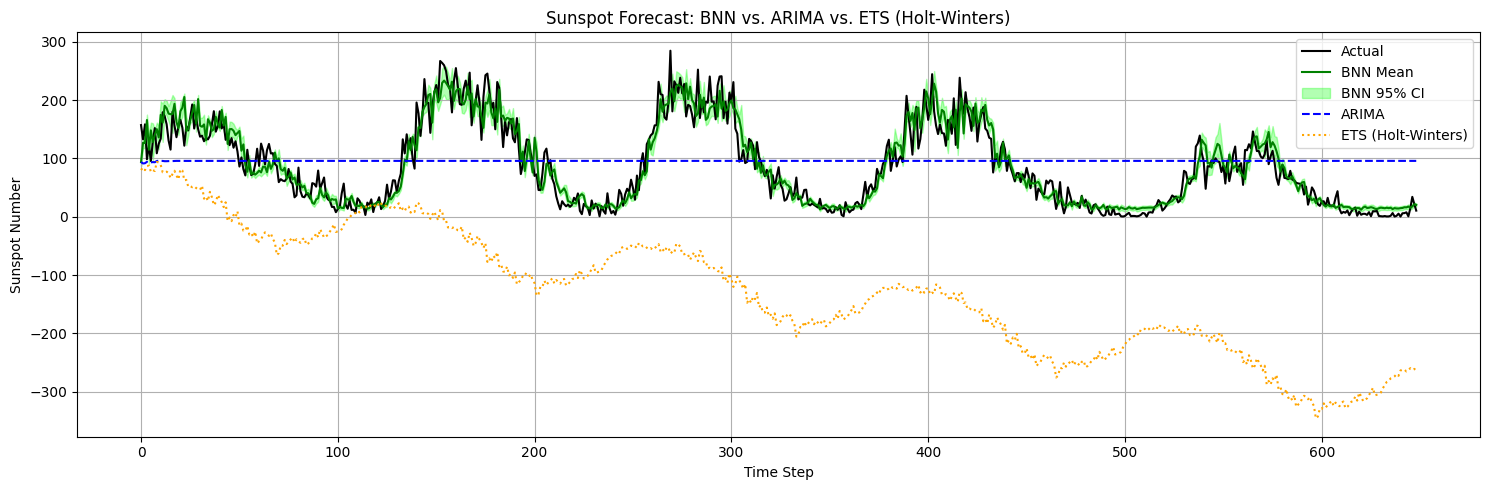

In [56]:
plt.figure(figsize=(15,5))
plt.plot(y_test_orig, label='Actual', color='black')
plt.plot(mean_pred_orig, label='BNN Mean', color='green')
plt.fill_between(np.arange(len(y_test_orig)),
                 mean_pred_orig - 2*std_pred_orig,
                 mean_pred_orig + 2*std_pred_orig,
                 color='lime', alpha=0.3, label='BNN 95% CI')
plt.plot(arima_forecast, label='ARIMA', color='blue', linestyle='dashed')
plt.plot(ets_forecast, label='ETS (Holt-Winters)', color='orange', linestyle='dotted')
plt.title('Sunspot Forecast: BNN vs. ARIMA vs. ETS (Holt-Winters)')
plt.xlabel('Time Step')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


ARIMA Test RMSE: 69.22, MAE: 57.97


/opt/anaconda3/envs/my_bnn/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Test RMSE: 83.85, MAE: 59.46
ETS (Holt-Winters) Test RMSE: 236.83, MAE: 215.98


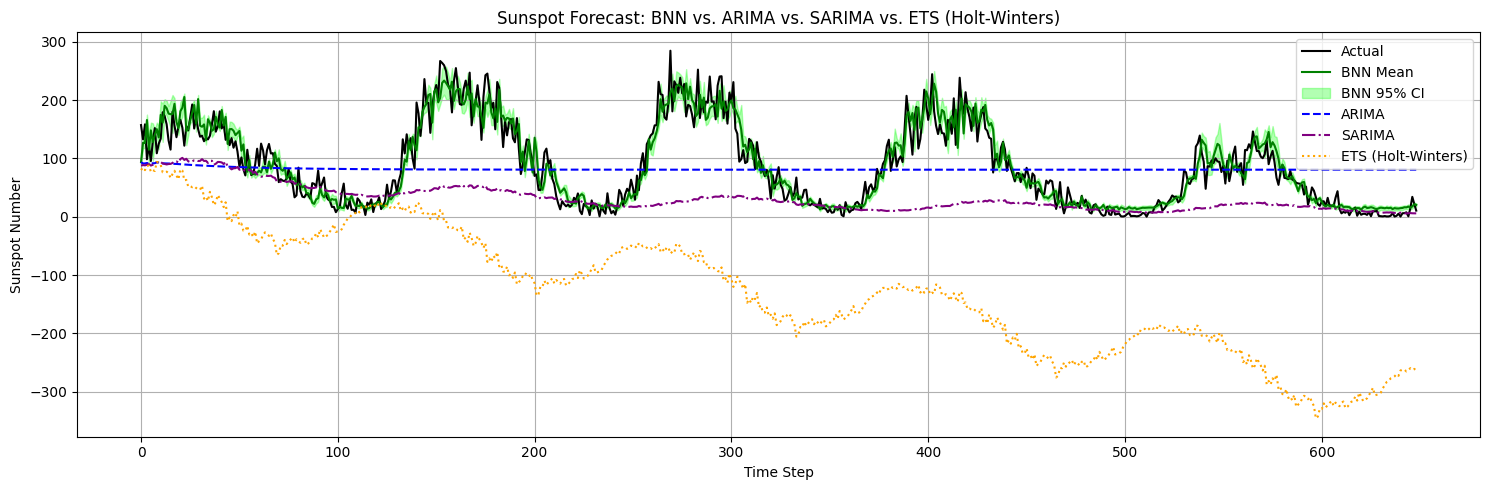


Test Set Performance Comparison:
Model                         RMSE       MAE
ARIMA                        69.22     57.97
SARIMA                       83.85     59.46
ETS (Holt-Winters)          236.83    215.98
Bayesian NN (BNN)            24.65     18.56


In [ ]:
train_series = series[:split_idx+window_size]  
forecast_steps = len(y_test)                   

# --- 1. ARIMA Baseline ---
arima_order = (12, 0, 0)  
arima_model = ARIMA(train_series, order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=forecast_steps)
arima_rmse = root_mean_squared_error(y_test_orig, arima_forecast)
arima_mae = mean_absolute_error(y_test_orig, arima_forecast)
print(f"ARIMA Test RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")

# --- 2. SARIMA Baseline ---
cycle_length = 132 if len(series) > 132 else 12  # 11-year solar cycle if possible
sarima_order = (2, 0, 2)                         
seasonal_order = (2, 0, 2, cycle_length)
sarima_model = SARIMAX(train_series, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)
sarima_rmse = root_mean_squared_error(y_test_orig, sarima_forecast)
sarima_mae = mean_absolute_error(y_test_orig, sarima_forecast)
print(f"SARIMA Test RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")

# --- 3. ETS (Holt-Winters) Baseline ---
ets_seasonal_period = cycle_length
ets_model = ExponentialSmoothing(
    train_series,
    trend='add',
    seasonal='add',
    seasonal_periods=ets_seasonal_period
).fit()
ets_forecast = ets_model.forecast(steps=forecast_steps)
ets_rmse = root_mean_squared_error(y_test_orig, ets_forecast)
ets_mae = mean_absolute_error(y_test_orig, ets_forecast)
print(f"ETS (Holt-Winters) Test RMSE: {ets_rmse:.2f}, MAE: {ets_mae:.2f}")

# --- 5. Visualization ---
plt.figure(figsize=(15,5))
plt.plot(y_test_orig, label='Actual', color='black')
plt.plot(mean_pred_orig, label='BNN Mean', color='green')
plt.fill_between(np.arange(len(y_test_orig)),
                 mean_pred_orig - 2*std_pred_orig,
                 mean_pred_orig + 2*std_pred_orig,
                 color='lime', alpha=0.3, label='BNN 95% CI')
plt.plot(arima_forecast, label='ARIMA', color='blue', linestyle='dashed')
plt.plot(sarima_forecast, label='SARIMA', color='purple', linestyle='dashdot')
plt.plot(ets_forecast, label='ETS (Holt-Winters)', color='orange', linestyle='dotted')
plt.title('Sunspot Forecast: BNN vs. ARIMA vs. SARIMA vs. ETS (Holt-Winters)')
plt.xlabel('Time Step')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- 6. Results Table ---
print("\nTest Set Performance Comparison:")
print(f"{'Model':<24}{'RMSE':>10}{'MAE':>10}")

print(f"{'SARIMA':<24}{sarima_rmse:10.2f}{sarima_mae:10.2f}")
print(f"{'ETS (Holt-Winters)':<24}{ets_rmse:10.2f}{ets_mae:10.2f}")
print(f"{'Bayesian NN (BNN)':<24}{rmse:10.2f}{mae:10.2f}")
